### Imported libraries

In [1]:
import csv
import copy
import itertools

import cv2 as cv
import numpy as np
import mediapipe as mp

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42

### Helper functions

#### A function that uses Tensorlfow lite model to classify hand sign

In [2]:
def KeyPointClassifier(landmark_list):
     model_path='model/Lite_model.tflite'
     num_threads=1

     # Intializing Tensorflow lite model
     interpreter =tf.lite.Interpreter(model_path=model_path,
                                               num_threads=num_threads)
     interpreter.allocate_tensors()
     input_details = interpreter.get_input_details()
     output_details = interpreter.get_output_details()

     # Setting input tensors and entering input data
     input_details_tensor_index = input_details[0]['index']
     interpreter.set_tensor(
            input_details_tensor_index,
            np.array([landmark_list], dtype=np.float32))
     
     # Running inference model
     interpreter.invoke()
     
     # Extracting output label from model
     output_details_tensor_index = output_details[0]['index']
     result = interpreter.get_tensor(output_details_tensor_index)
     result_index = np.argmax(np.squeeze(result))

     return result_index


#### A function reads from user to change modes

In [3]:
def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 to 9
        number = key - 48
    if key == 118:  # v
        mode = 0 # Normal Camera mode
    if key == 99:  # c
        mode = 1 # Data capturing mode
    return number, mode

#### Function to Calculate Landmark list

In [4]:
def draw_landmark_list(image,handslms,handedness):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []
    
    mp_draw = mp.solutions.drawing_utils
    mp_hands = mp.solutions.hands
    # Keypoint
    for _, landmark in enumerate(handslms.landmark):
        landmark_x = int(landmark.x * image_width)
        landmark_y = int(landmark.y * image_height)

        landmark_point.append([landmark_x, landmark_y])

        if handedness.classification[0].label == "Left":
            color = (0,0,255)
        else:
            color = (255,0,255)
    
    mp_draw.draw_landmarks(image,handslms,mp_hands.HAND_CONNECTIONS,
                           landmark_drawing_spec=mp_draw.DrawingSpec(color =color))
    return np.array(landmark_point)

#### Functions to normalize data to feed into model

In [5]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

#### Function to Create data

In [6]:
def logging_csv(number, mode, landmark_list):
    if mode == 0:
        pass
    if mode == 1 and (0 <= number <= 9):
        csv_path = 'Dataset/keypoint.csv'
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *landmark_list])
    return

#### Function to draw Rectangle around hand

In [7]:
def draw_bounding_rect(use_rect, image, rect):
    if use_rect:
        # Outer rectangle
        cv.rectangle(image, (rect[0], rect[1]), (rect[2], rect[3]),
                     (0, 0, 0), 1)

    return image

#### Function to write sign

In [8]:
def draw_info_text(image, rect, handedness, hand_sign_text):
    cv.rectangle(image, (rect[0], rect[1]), (rect[2], rect[1] - 22),
                 (0, 0, 0), -1)

    info_text = handedness.classification[0].label[0:]
    if hand_sign_text != "":
        info_text = info_text + ':' + hand_sign_text
    cv.putText(image, info_text, (rect[0] + 5, rect[1] - 4),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv.LINE_AA)

    return image

#### Function to write mode

In [9]:
def draw_info(image,mode, number):
    mode_string = ['Logging Key Point', 'Logging Point History']
    if 1 == mode:
        cv.putText(image, "MODE:" + mode_string[mode - 1], (10, 90),
                   cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1,
                   cv.LINE_AA)
        if 0 <= number <= 9:
            cv.putText(image, "NUM:" + str(number), (10, 110),
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1,
                       cv.LINE_AA)
    return image

### Model for Sign recogntion

#### Fetching  and splitting data

In [10]:
dataset = 'Dataset/keypoint.csv'
model_save_path = 'model/Lite_model.hdf5'

X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

#### Intiatlizing, compiling and training model 

In [11]:
NUM_CLASSES = 8
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 40)                1720      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                2460      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1220      
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [12]:
# saving checkpoints of model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

# Early stopping if model doesn't improve for 20 epochs
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


52/60 [=========================>....] - ETA: 0s - loss: 2.0021 - accuracy: 0.2362
Epoch 1: saving model to model\Lite_model.hdf5
60/60 [==============================] - 2s 14ms/step - loss: 1.9921 - accuracy: 0.2375 - val_loss: 1.8427 - val_accuracy: 0.2694
Epoch 2/1000
51/60 [========================>.....] - ETA: 0s - loss: 1.7959 - accuracy: 0.3039
Epoch 2: saving model to model\Lite_model.hdf5
60/60 [==============================] - 0s 7ms/step - loss: 1.7787 - accuracy: 0.3096 - val_loss: 1.5086 - val_accuracy: 0.3578
Epoch 3/1000
59/60 [============================>.] - ETA: 0s - loss: 1.5620 - accuracy: 0.3774
Epoch 3: saving model to model\Lite_model.hdf5
60/60 [==============================] - 1s 9ms/step - loss: 1.5621 - accuracy: 0.3770 - val_loss: 1.2915 - val_accuracy: 0.5039
Epoch 4/1000
55/60 [==========================>...] - ETA: 0s - loss: 1.4093 - accuracy: 0.4278
Epoch 4: saving model to model\Lite_model.hdf5
60/60 [==============================] - 1s 9ms/step 

#### Evaluation using confusion matrix

40/40 [==============================] - 0s 2ms/step


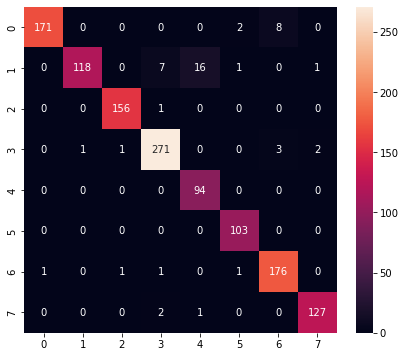

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       181
           1       0.99      0.83      0.90       143
           2       0.99      0.99      0.99       157
           3       0.96      0.97      0.97       278
           4       0.85      1.00      0.92        94
           5       0.96      1.00      0.98       103
           6       0.94      0.98      0.96       180
           7       0.98      0.98      0.98       130

    accuracy                           0.96      1266
   macro avg       0.96      0.96      0.96      1266
weighted avg       0.96      0.96      0.96      1266



In [15]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

labels = sorted(list(set(y_test)))
cmx_data = confusion_matrix(y_test, y_pred, labels=labels)
    
df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
ax.set_ylim(len(set(y_test)), 0)
plt.show()
    

print('Classification Report')
print(classification_report(y_test, y_pred))

#### Saving model for tensorflow lite use

In [16]:
model.save(model_save_path, include_optimizer=False)

tflite_save_path = 'model/Lite_model.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\BSBSME~1\AppData\Local\Temp\tmp46am9jpi\assets


9000

### Main Application

In [17]:
# Setting video capture configs
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 1080)

# Loading Mediapipe model 
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
        static_image_mode= True,
        max_num_hands=4, 
        min_detection_confidence=0.7,
        min_tracking_confidence=0.5,
    )

#Reading Labels 
with open('Dataset/keypoint_classifier_label.csv',
              encoding='utf-8-sig') as f:
        keypoint_classifier_labels = csv.reader(f)
        keypoint_classifier_labels = [
            row[0] for row in keypoint_classifier_labels
        ]

mode = 0

In [18]:
while True:

    key = cv.waitKey(10)
    if key == 27:  # ESC
        break

    number,mode = select_mode(key,mode)

    # Capturing Frame
    ret, image = cap.read()
    if not ret:
        break
    

    # Flipping image for mediapipe
    image = cv.flip(image, 1)

    #copying image to draw on
    debug_image = copy.deepcopy(image)
    
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    #processing image to mediapipe to get hand landmarks
    image.flags.writeable = False
    results = hands.process(image)
    image.flags.writeable = True

    if results.multi_hand_landmarks is not None:
        for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                  results.multi_handedness):
            # Calculating landmarks
            landmark_list = draw_landmark_list(debug_image,hand_landmarks,handedness)

            # Calculate Bounding Box
            x, y, w, h = cv.boundingRect(landmark_list)
            rect = [x, y, x + w, y + h]
            
            # Conversion to normalized coordinates
            pre_processed_landmark_list = pre_process_landmark(
                landmark_list)
                        
            # Write to the dataset file
            logging_csv(number, mode, pre_processed_landmark_list)

            # Hand sign classification
            hand_sign_id = KeyPointClassifier(pre_processed_landmark_list)

            # Drawing part
            debug_image = draw_bounding_rect(True, debug_image, rect)
            #debug_image = draw_landmarks(debug_image, landmark_list)
            debug_image = draw_info_text(
                debug_image,
                rect,
                handedness,
                keypoint_classifier_labels[hand_sign_id],
            )
    debug_image = draw_info(debug_image, mode, number)

    # Screen show
    cv.imshow('Hand Gesture Recognition', debug_image)
cap.release()
cv.destroyAllWindows()